11 topics

In [427]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.externals import joblib
from sklearn import metrics
from tqdm import tqdm

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [428]:
raw_documents = []
snippets = []
with open( "data/data.txt", "r") as f:
    for line in f.readlines():
        text = line.strip()
        raw_documents.append( text.lower().replace('brexit', 'british exit').replace('lloyds', 'financial').replace('labour', 'work').replace('corbyn', 'opposition').replace('turnbull', 'bull') )
        
        snippets.append( text[0:min(len(text),100)] )
print("Read %d raw text documents" % len(raw_documents))

Read 4551 raw text documents


In [429]:
# custom stopwords
custom_stop_words = []
with open( "data/stopwords.txt", "r" ) as f:
    for line in f.readlines():
        custom_stop_words.append( line.strip().lower().replace('brexit', 'british exit').replace('lloyds', 'financial').replace('labour', 'work').replace('corbyn', 'opposition').replace('turnbull', 'bull') )
        
print("Stopword list has %d entries" % len(custom_stop_words) )

Stopword list has 350 entries


In [430]:
# create BoW + tf-idf model
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df = 20)
A = vectorizer.fit_transform(raw_documents)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )

terms = vectorizer.get_feature_names() 

Created 4551 X 10280 TF-IDF-normalized document-term matrix


In [431]:
# create the model
k = 11
model = TruncatedSVD(n_components=k ) 

W = model.fit_transform( A )
H = model.components_

In [432]:
W.shape

(4551, 11)

In [433]:
W[0,:].round(2)

array([ 0.12, -0.06,  0.02, -0.05,  0.24, -0.1 ,  0.  , -0.04,  0.11,
        0.02, -0.07])

In [434]:
H.shape

(11, 10280)

In [435]:
H[:,terms.index('uk')].round(2)

array([ 0.1 , -0.12,  0.15,  0.03, -0.01, -0.03, -0.01,  0.04, -0.25,
        0.02, -0.03])

In [436]:
# show topic descriptors
def get_descriptor( terms, H, topic_index, top ):
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 10 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: trump, eu, people, british, clinton, uk, exit, campaign, work, time
Topic 02: trump, clinton, republican, donald, hillary, cruz, president, sanders, presidential, campaign
Topic 03: eu, british, exit, uk, britain, vote, referendum, leave, trump, european
Topic 04: league, eu, season, leicester, premier, goal, united, liverpool, ball, city
Topic 05: bank, banks, financial, banking, customers, rbs, shares, deutsche, barclays, hsbc
Topic 06: health, nhs, care, mental, patients, doctors, hospital, people, social, services
Topic 07: album, music, band, song, songs, pop, rock, bowie, sound, guitar
Topic 08: facebook, internet, online, google, twitter, users, media, company, amazon, technology
Topic 09: party, bank, cameron, work, opposition, campaign, voters, banks, johnson, mps
Topic 10: women, mental, health, abortion, people, men, cancer, woman, children, bank
Topic 11: clinton, sanders, vote, cruz, exit, voters, british, pound, growth, party


In [437]:
def get_top_snippets( all_snippets, W, topic_index, top ):
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append( all_snippets[doc_index] )
    return top_snippets

topic_snippets = get_top_snippets( snippets, W, 0, 10 )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), snippet ) )

01. Obama talks trans bathroom access as Trump defends business practices – as it happened Here are the 
02. Melania Trump defends husband's 'boy talk' in CNN interview – as it happened Speaking to CNN’s Ander
03. Hillary Clinton: 'I'm sick of the Sanders campaign's lies' – as it happened One of the most importan
04. Donald Trump hits delegate count needed for Republican nomination – as it happened On the one hand, 
05. Trump campaign reportedly vetting Christie, Gingrich as potential running mates – as it happened Don
06. Clinton seizes on Trump tweets for day of campaigning in Florida – as it happened Donald Trump was a
07. Trump wins Washington primary as protests erupt by Albuquerque rally – as it happened Donald Trump w
08. DNC 2016, day three: emotional Obama passes baton to Clinton – as it happened The sun has set on day
09. Donald Trump: money raised by Hillary Clinton is 'blood money' – as it happened Hillary Clinton deli
10. Donald Trump: Hillary Clinton has 'no right to be r

In [438]:
kmin, kmax = 4, 15

topic_models = []
for k in tqdm(range(kmin,kmax+1)):
    model = TruncatedSVD(n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    topic_models.append( (k,W,H) )

100%|██████████| 12/12 [00:02<00:00,  4.51it/s]


In [439]:
!pip3 install --upgrade gensim

Requirement already up-to-date: gensim in /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages (3.8.1)


In [440]:
import gensim
import gensim.models.keyedvectors as word2vec

w2v_model = word2vec.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
print( "Model has %d terms" % len(w2v_model.wv.vocab) )

Model has 3000000 terms


<ipython-input-440-14470ac107fb>:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  print( "Model has %d terms" % len(w2v_model.wv.vocab) )


In [441]:
from itertools import combinations


def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=04: Coherence=0.1548
K=05: Coherence=0.1777
K=06: Coherence=0.1904
K=07: Coherence=0.2188
K=08: Coherence=0.2221
K=09: Coherence=0.2116
K=10: Coherence=0.2117
K=11: Coherence=0.2011
K=12: Coherence=0.1957
K=13: Coherence=0.1893
K=14: Coherence=0.1920
K=15: Coherence=0.1847


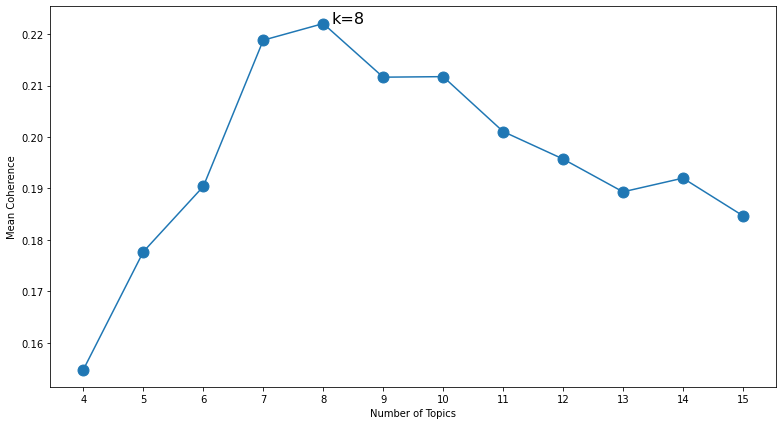

In [442]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

In [443]:
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: trump, eu, people, british, clinton, uk, exit, campaign, work, time
Topic 02: trump, clinton, republican, donald, hillary, cruz, president, sanders, presidential, campaign
Topic 03: eu, british, exit, uk, britain, vote, referendum, leave, trump, european
Topic 04: league, eu, season, leicester, premier, goal, united, liverpool, ball, city
Topic 05: bank, banks, financial, banking, customers, rbs, shares, deutsche, barclays, hsbc
Topic 06: health, nhs, care, mental, patients, doctors, hospital, people, social, services
Topic 07: album, music, song, band, songs, pop, rock, sound, bowie, guitar
Topic 08: facebook, internet, online, twitter, google, users, media, amazon, company, technology


7 topics

In [444]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.externals import joblib
from sklearn import metrics
from tqdm import tqdm

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [445]:
raw_documents = []
snippets = []
with open( "data/data.txt", "r") as f:
    for line in f.readlines():
        text = line.strip()
        raw_documents.append( text.lower().replace('brexit', 'british exit').replace('lloyds', 'financial').replace('labour', 'work').replace('corbyn', 'opposition').replace('turnbull', 'bull') )
        
        snippets.append( text[0:min(len(text),100)] )
print("Read %d raw text documents" % len(raw_documents))

Read 4551 raw text documents


In [446]:
# custom stopwords
custom_stop_words = []
with open( "data/stopwords.txt", "r" ) as f:
    for line in f.readlines():
        custom_stop_words.append( line.strip().lower().replace('brexit', 'british exit').replace('lloyds', 'financial').replace('labour', 'work').replace('corbyn', 'opposition').replace('turnbull', 'bull') )
        
print("Stopword list has %d entries" % len(custom_stop_words) )

Stopword list has 350 entries


In [447]:
# create BoW + tf-idf model
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df = 20)
A = vectorizer.fit_transform(raw_documents)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )

terms = vectorizer.get_feature_names() 

Created 4551 X 10280 TF-IDF-normalized document-term matrix


In [448]:
# create the model
k = 7
model = TruncatedSVD(n_components=k ) 

W = model.fit_transform( A )
H = model.components_

In [449]:
W.shape

(4551, 7)

In [450]:
W[0,:].round(2)

array([ 0.12, -0.06,  0.02, -0.05,  0.24, -0.1 ,  0.  ])

In [451]:
H.shape

(7, 10280)

In [452]:
H[:,terms.index('uk')].round(2)

array([ 0.1 , -0.12,  0.15,  0.03, -0.01, -0.03, -0.01])

In [453]:
# show topic descriptors
def get_descriptor( terms, H, topic_index, top ):
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 10 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: trump, eu, people, british, clinton, uk, exit, campaign, work, time
Topic 02: trump, clinton, republican, donald, hillary, cruz, president, sanders, presidential, campaign
Topic 03: eu, british, exit, uk, britain, vote, referendum, leave, trump, european
Topic 04: league, eu, season, leicester, premier, goal, united, liverpool, ball, city
Topic 05: bank, banks, financial, banking, customers, rbs, shares, deutsche, barclays, hsbc
Topic 06: health, nhs, care, mental, patients, doctors, hospital, people, social, services
Topic 07: album, music, band, song, songs, pop, rock, bowie, sound, guitar


In [454]:
def get_top_snippets( all_snippets, W, topic_index, top ):
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append( all_snippets[doc_index] )
    return top_snippets

topic_snippets = get_top_snippets( snippets, W, 0, 10 )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), snippet ) )

01. Obama talks trans bathroom access as Trump defends business practices – as it happened Here are the 
02. Melania Trump defends husband's 'boy talk' in CNN interview – as it happened Speaking to CNN’s Ander
03. Hillary Clinton: 'I'm sick of the Sanders campaign's lies' – as it happened One of the most importan
04. Donald Trump hits delegate count needed for Republican nomination – as it happened On the one hand, 
05. Trump campaign reportedly vetting Christie, Gingrich as potential running mates – as it happened Don
06. Clinton seizes on Trump tweets for day of campaigning in Florida – as it happened Donald Trump was a
07. Trump wins Washington primary as protests erupt by Albuquerque rally – as it happened Donald Trump w
08. DNC 2016, day three: emotional Obama passes baton to Clinton – as it happened The sun has set on day
09. Donald Trump: money raised by Hillary Clinton is 'blood money' – as it happened Hillary Clinton deli
10. Donald Trump: Hillary Clinton has 'no right to be r

In [455]:
kmin, kmax = 4, 15

topic_models = []
for k in tqdm(range(kmin,kmax+1)):
    model = TruncatedSVD(n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    topic_models.append( (k,W,H) )

100%|██████████| 12/12 [00:02<00:00,  4.18it/s]


In [456]:
from itertools import combinations


def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=04: Coherence=0.1548
K=05: Coherence=0.1777
K=06: Coherence=0.1904
K=07: Coherence=0.2188
K=08: Coherence=0.2221
K=09: Coherence=0.2130
K=10: Coherence=0.2145
K=11: Coherence=0.2061
K=12: Coherence=0.1962
K=13: Coherence=0.1900
K=14: Coherence=0.1917
K=15: Coherence=0.1832


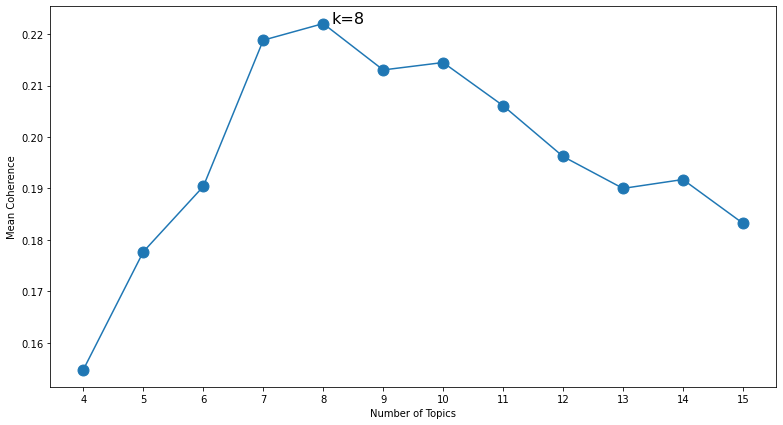

In [457]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

In [458]:
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 7 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: trump, eu, people, british, clinton, uk, exit
Topic 02: trump, clinton, republican, donald, hillary, cruz, president
Topic 03: eu, british, exit, uk, britain, vote, referendum
Topic 04: league, eu, season, leicester, premier, goal, united
Topic 05: bank, banks, financial, banking, customers, rbs, shares
Topic 06: health, nhs, care, mental, patients, doctors, hospital
Topic 07: album, music, band, song, songs, pop, rock
Topic 08: facebook, internet, online, twitter, google, users, media


5 topics

In [459]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.externals import joblib
from sklearn import metrics
from tqdm import tqdm

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [460]:
raw_documents = []
snippets = []
with open( "data/data.txt", "r") as f:
    for line in f.readlines():
        text = line.strip()
        raw_documents.append( text.lower().replace('brexit', 'british exit').replace('lloyds', 'financial').replace('labour', 'work').replace('corbyn', 'opposition').replace('turnbull', 'bull') )
        
        snippets.append( text[0:min(len(text),100)] )
print("Read %d raw text documents" % len(raw_documents))

Read 4551 raw text documents


In [461]:
# custom stopwords
custom_stop_words = []
with open( "data/stopwords.txt", "r" ) as f:
    for line in f.readlines():
        custom_stop_words.append( line.strip().lower().replace('brexit', 'british exit').replace('lloyds', 'financial').replace('labour', 'work').replace('corbyn', 'opposition').replace('turnbull', 'bull') )
        
print("Stopword list has %d entries" % len(custom_stop_words) )

Stopword list has 350 entries


In [462]:
# create BoW + tf-idf model
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df = 20)
A = vectorizer.fit_transform(raw_documents)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )

terms = vectorizer.get_feature_names() 

Created 4551 X 10280 TF-IDF-normalized document-term matrix


In [463]:
# create the model
k = 11
model = TruncatedSVD(n_components=k ) 

W = model.fit_transform( A )
H = model.components_

In [464]:
W.shape

(4551, 11)

In [465]:
W[0,:].round(2)

array([ 0.12, -0.06,  0.02, -0.05,  0.24, -0.1 ,  0.  , -0.04,  0.12,
        0.03, -0.08])

In [466]:
H.shape

(11, 10280)

In [467]:
H[:,terms.index('uk')].round(2)

array([ 0.1 , -0.12,  0.15,  0.03, -0.01, -0.03, -0.01,  0.04, -0.25,
        0.01, -0.02])

In [468]:
# show topic descriptors
def get_descriptor( terms, H, topic_index, top ):
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 10 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: trump, eu, people, british, clinton, uk, exit, campaign, work, time
Topic 02: trump, clinton, republican, donald, hillary, cruz, president, sanders, presidential, campaign
Topic 03: eu, british, exit, uk, britain, vote, referendum, leave, trump, european
Topic 04: league, eu, season, leicester, premier, goal, united, liverpool, ball, city
Topic 05: bank, banks, financial, banking, customers, rbs, shares, deutsche, barclays, hsbc
Topic 06: health, nhs, care, mental, patients, doctors, hospital, people, social, services
Topic 07: album, music, band, song, songs, pop, rock, bowie, sound, guitar
Topic 08: facebook, internet, online, google, twitter, users, media, amazon, company, technology
Topic 09: party, bank, cameron, work, opposition, campaign, voters, banks, johnson, mps
Topic 10: women, mental, health, abortion, people, men, cancer, woman, children, bank
Topic 11: clinton, sanders, vote, cruz, mental, exit, voters, growth, pound, rubio


In [469]:
def get_top_snippets( all_snippets, W, topic_index, top ):
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append( all_snippets[doc_index] )
    return top_snippets

topic_snippets = get_top_snippets( snippets, W, 0, 10 )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), snippet ) )

01. Obama talks trans bathroom access as Trump defends business practices – as it happened Here are the 
02. Melania Trump defends husband's 'boy talk' in CNN interview – as it happened Speaking to CNN’s Ander
03. Hillary Clinton: 'I'm sick of the Sanders campaign's lies' – as it happened One of the most importan
04. Donald Trump hits delegate count needed for Republican nomination – as it happened On the one hand, 
05. Trump campaign reportedly vetting Christie, Gingrich as potential running mates – as it happened Don
06. Clinton seizes on Trump tweets for day of campaigning in Florida – as it happened Donald Trump was a
07. Trump wins Washington primary as protests erupt by Albuquerque rally – as it happened Donald Trump w
08. DNC 2016, day three: emotional Obama passes baton to Clinton – as it happened The sun has set on day
09. Donald Trump: money raised by Hillary Clinton is 'blood money' – as it happened Hillary Clinton deli
10. Donald Trump: Hillary Clinton has 'no right to be r

In [470]:
kmin, kmax = 4, 15

topic_models = []
for k in tqdm(range(kmin,kmax+1)):
    model = TruncatedSVD(n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    topic_models.append( (k,W,H) )

100%|██████████| 12/12 [00:02<00:00,  4.49it/s]


In [471]:
from itertools import combinations


def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=04: Coherence=0.1548
K=05: Coherence=0.1777
K=06: Coherence=0.1904
K=07: Coherence=0.2188
K=08: Coherence=0.2221
K=09: Coherence=0.2136
K=10: Coherence=0.2127
K=11: Coherence=0.2038
K=12: Coherence=0.1916
K=13: Coherence=0.1877
K=14: Coherence=0.1888
K=15: Coherence=0.1836


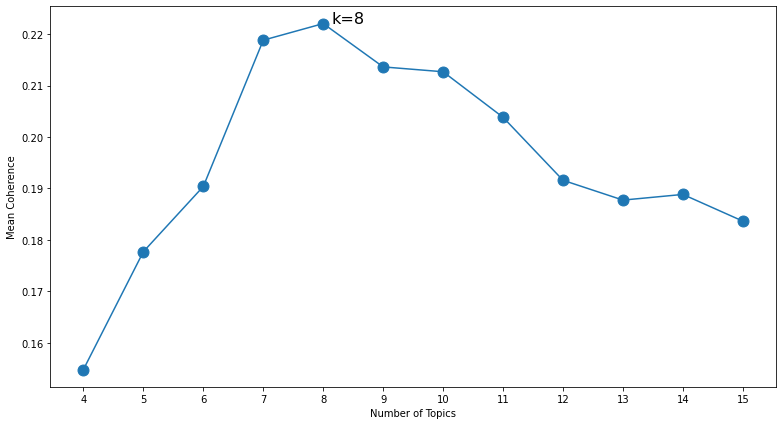

In [472]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

In [473]:
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: trump, eu, people, british, clinton
Topic 02: trump, clinton, republican, donald, hillary
Topic 03: eu, british, exit, uk, britain
Topic 04: league, eu, season, leicester, premier
Topic 05: bank, banks, financial, banking, customers
Topic 06: health, nhs, care, mental, patients
Topic 07: album, music, song, band, songs
Topic 08: facebook, internet, online, twitter, google


attention

In [474]:
from sklearn.cluster import KMeans
import numpy as np
import gensim
import codecs
import tqdm
import os


class word2vec:

    def __init__(self, corpus_path):
        self.corpus_path = corpus_path
        self.n_vocab = 0

    def __iter__(self):
        with codecs.open(self.corpus_path, 'r', 'utf-8') as f:
            for line in tqdm.tqdm(f, desc='training'):
                yield line.split()

    def add_word(self, *words):
        for word in words:
            if not word in self.w2i:
                self.w2i[word] = self.n_vocab
                self.i2w[self.w2i[word]] = word
                self.n_vocab += 1

    def embed(self, model_path, d_embed,
              max_n_vocab=None, window=5, min_count=10, workers=16):
        self.d_embed = d_embed
        if os.path.isfile(model_path):
            model = gensim.models.Word2Vec.load(model_path)
        else:
            model = gensim.models.Word2Vec(self,
                size=d_embed, max_final_vocab=max_n_vocab,
                window=window, min_count=min_count, workers=workers)
            model.save(model_path)
            model = gensim.models.Word2Vec.load(model_path)
        self.i2w, self.w2i = {}, {}
        self.E = []
        n = len(model.wv.vocab)
        for word in sorted(model.wv.vocab):
            self.add_word(word)
            self.E.append(list(model.wv[word]))
        else:
            self.add_word('<unk>')
            self.E.append([0] * d_embed)
        self.E = np.asarray(self.E).astype(np.float32)
        return self

    def aspect(self, n_aspects):
        self.n_aspects = n_aspects
        km = KMeans(n_clusters=n_aspects, random_state=0)
        km.fit(self.E)
        self.T = km.cluster_centers_.astype(np.float32)
        self.T /= np.linalg.norm(self.T, axis=-1, keepdims=True)
        return self


In [475]:
def linecount(path, chunk=(8192 * 1024)):
    lc = 0
    with open(path, 'rb') as f:
        buf = f.read(chunk)
        while buf:
            lc += buf.count(b'\n')
            buf = f.read(chunk)
    return lc

In [476]:
from torch.nn.functional import normalize
import torch.optim as optim
import torch

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import collections
import numpy as np
import tqdm


def max_margin_loss(r_s, z_s, z_n):
    device = r_s.device
    pos = torch.bmm(z_s.unsqueeze(1), r_s.unsqueeze(2)).squeeze(2)
    negs = torch.bmm(z_n, r_s.unsqueeze(2)).squeeze()
    J = torch.ones(negs.shape).to(device) - pos.expand(negs.shape) + negs
    return torch.sum(torch.clamp(J, min=0.0))


def orthogonal_regularization(T):
    T_n = normalize(T, dim=1)
    I = torch.eye(T_n.shape[0]).to(T_n.device)
    return torch.norm(T_n.mm(T_n.t()) - I)


def train(ab, dl, device='cuda', epochs=5, epochsize=100,
          initial_lr=0.02, batchsize=4, negsize=20, ortho_reg=0.1):
    batches = dl.batch_generator('train', device, batchsize, negsize)
    i2w = dict((dl.w2i[w], w) for w in dl.w2i)

    opt = optim.Adam(ab.parameters(), lr=initial_lr)
    plot = plotter()

    epoch_losses = collections.defaultdict(list)
    ab.eval()
    val_loss = validate(ab, dl, device, 'val', epochsize,
                        batchsize, negsize, ortho_reg)
    ab.train()
    epoch_losses['Training Loss'].append(float('inf'))
    epoch_losses['Validation Loss'].append(val_loss)
    sample_aspects(ab.aspects(), i2w)
    plot(epoch_losses)

    for e in range(epochs):
        train_losses = []
        with tqdm.trange(epochsize) as pbar:
            for b in pbar:
                pos, neg = next(batches)
                r_s, z_s, z_n = ab(pos, neg)
                J = max_margin_loss(r_s, z_s, z_n)
                U = orthogonal_regularization(ab.T.weight)
                loss = J + ortho_reg * batchsize * U
                opt.zero_grad()
                loss.backward()
                opt.step()

                train_losses.append(loss.item())
                x = (e + 1, opt.param_groups[0]['lr'], train_losses[-1])
                d = 'TRAIN EPOCH: %d | LR: %0.5f | MEAN-TRAIN-LOSS: %0.5f' % x
                pbar.set_description(d)

                if b * batchsize % 100 == 0:
                    lr = initial_lr * (1.0 - 1.0 * ((e + 1) * (b + 1)) / (epochs * epochsize))
                    for pg in opt.param_groups:
                        pg['lr'] = lr

        ab.eval()
        val_loss = validate(ab, dl, device, 'val', epochsize,
                            batchsize, negsize, ortho_reg)
        ab.train()
        epoch_losses['Training Loss'].append(np.mean(train_losses))
        epoch_losses['Validation Loss'].append(val_loss)
        sample_aspects(ab.aspects(), i2w)
        plot(epoch_losses)

    ab.eval()


def validate(ab, dl, device='cuda', split='val',
             epochsize=100, batchsize=4, negsize=20, ortho_reg=0.1):
    losses = []
    batches = dl.batch_generator(split, device, batchsize, negsize)
    with tqdm.tqdm(range(epochsize), total=epochsize, desc='validating') as pbar:
        for b in pbar:
            pos, neg = next(batches)
            r_s, z_s, z_n = ab(pos, neg)
            J = max_margin_loss(r_s, z_s, z_n).item()
            U = orthogonal_regularization(ab.T.weight).item()
            losses.append((J + ortho_reg * batchsize * U))
            x = (b + 1, np.mean(losses))
            pbar.set_description('VAL BATCH: %d | MEAN-VAL-LOSS: %0.5f' % x)
    return np.mean(losses)


def plotter(figsize=(8, 4)):
    f, ax = plt.subplots(1, 1, figsize=figsize)

    def plot_losses(losses):
        colors = cm.rainbow(np.linspace(0, 1, len(losses)))
        lines = []
        for loss, color in zip(losses, colors):
            y = losses[loss]
            x = list(range(len(y)))
            l = ax.plot(x, y, color=color, label=loss, lw=4, marker='o')
            lines.append(loss)
        ax.legend(lines)
        ax.semilogy()
        ax.set_title('Losses')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_xticks(x)
        f.canvas.draw()

    return plot_losses


def sample_aspects(projection, i2w, n=8):
    projection = torch.sort(projection, dim=1)
    for j, (projs, index) in enumerate(zip(*projection)):
        index = index[-n:].detach().cpu().numpy()
        words = ', '.join([i2w[i] for i in index])
        print('Aspect %2d: %s' % (j, words))

In [477]:
import torch.nn as nn
import torch
from torch.nn.functional import normalize, softmax


class attention(nn.Module):

    def __init__(self, d_embed):
        super(attention, self).__init__()
        self.M = nn.Linear(d_embed, d_embed)
        self.M.weight.data.uniform_(-0.1, 0.1)

    def forward(self, e_i):
        y_s = torch.mean(e_i, dim=-1)
        d_i = torch.bmm(e_i.transpose(1, 2), self.M(y_s).unsqueeze(2)).tanh()
        a_i = softmax(d_i)
        return a_i.squeeze(1)


class abae(nn.Module):

    def __init__(self, E, T):
        super(abae, self).__init__()
        n_vocab, d_embed = E.shape
        n_aspects, d_embed = T.shape
        self.E = nn.Embedding(n_vocab, d_embed)
        self.T = nn.Embedding(n_aspects, d_embed)
        self.attention = attention(d_embed)
        self.linear = nn.Linear(d_embed, n_aspects)
        self.E.weight = nn.Parameter(torch.from_numpy(E), requires_grad=False)
        self.T.weight = nn.Parameter(torch.from_numpy(T), requires_grad=True)

    def forward(self, pos, negs):
        p_t, z_s = self.predict(pos)
        r_s = normalize(torch.mm(self.T.weight.t(), p_t.t()).t(), dim=-1)
        e_n = self.E(negs).transpose(-2, -1)
        z_n = normalize(torch.mean(e_n, dim=-1), dim=-1)
        return r_s, z_s, z_n

    def predict(self, x):
        e_i = self.E(x).transpose(1, 2)
        a_i = self.attention(e_i)
        z_s = normalize(torch.bmm(e_i, a_i).squeeze(2), dim=-1)
        p_t = softmax(self.linear(z_s), dim=1)
        return p_t, z_s

    def aspects(self):
        E_n = normalize(self.E.weight, dim=1)
        T_n = normalize(self.T.weight, dim=1)
        projection = torch.mm(E_n, T_n.t()).t()
        return projection


In [478]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import numpy as np
import torch
import mmap
import tqdm
import traceback
import json
import os

lmtzr = WordNetLemmatizer().lemmatize
stop = stopwords.words('english')
token = CountVectorizer().build_tokenizer()


def preprocess_sentence(x):
    return [lmtzr(t) for t in token(x.lower()) if not t in stop]


def preprocess(input_path, output_path):
    with open(input_path, 'r') as in_f, open(output_path, 'w') as out_f:
        lc = linecount(input_path)
        desc = 'preprocessing "%s"' % input_path
        for j, l in tqdm.tqdm(enumerate(in_f), total=lc, desc=desc):
            tokens = preprocess_sentence(l)
            n_tokens = len(tokens)
            if len(tokens) > 5 and n_tokens < 100:
                out_l = ' '.join(tokens)
                out_f.write(out_l + '\n')


class dataloader:

    def __init__(self, w2i, path, split=None, seed=0):
        self.w2i = w2i
        self.path = path
        self.meta = './.' + os.path.basename(self.path) + '.meta.json'
        self.split = split if split else {'train': 1.0}
        np.random.seed(seed)

    def __enter__(self):
        self.f = open(self.path, 'rb')
        self.data = mmap.mmap(self.f.fileno(), 0, access=mmap.ACCESS_COPY)
        if os.path.isfile(self.meta):
            self.read_meta()
        else:
            self.offsets = dict((s, []) for s in self.split)
            splits, probs = zip(*list(self.split.items()))
            desc = 'finding offsets in "%s"' % self.path
            i = 0
            for j, char in enumerate(tqdm.tqdm(self.data, desc=desc)):
                if char == b'\n':
                    split = splits[np.random.choice(len(probs), p=probs)]
                    self.offsets[split].append((i, j))
                    i = j + 1
            self.linecounts = dict((s, len(self.offsets[s])) for s in self.split)
            self.linecount = sum(self.linecounts[s] for s in self.split)
            self.write_meta()
        return self

    def __exit__(self, *ags):
        if ags[1]:
            traceback.print_exception(*ags)
        self.f.close()
        return True

    def write_meta(self):
        meta = {
            'path': self.path,
            'linecount': self.linecount,
            'linecounts': self.linecounts,
            'offsets': self.offsets,
        }
        with open(self.meta, 'w') as f:
            f.write(json.dumps(meta))

    def read_meta(self):
        with open(self.meta, 'r') as f:
            meta = json.loads(f.read())
        assert(self.path == meta['path'])
        self.linecount = meta['linecount']
        self.linecounts = meta['linecounts']
        self.offsets = meta['offsets']

    def b2i(self, batch):
        batch = [self.data[u:v].decode('utf').split() for u, v in batch]
        lengths = [len(l) for l in batch]
        index = np.zeros((len(batch), max(lengths)))
        w2i = lambda w: (self.w2i[w] if w in self.w2i else self.w2i['<unk>'])
        for j, (words, length) in enumerate(zip(batch, lengths)):
            index[j, :length] = [w2i(w) for w in words]
        return torch.LongTensor(index)

    def batch_generator(self, split='train', device='cpu', batchsize=20, negsize=20):
        linecount = self.linecounts[split]
        batchcount = (linecount // batchsize)
        pos_offsets = self.offsets[split][:]
        neg_offsets = self.offsets[split][:]
        np.random.shuffle(pos_offsets)
        np.random.shuffle(neg_offsets)
        batches = 0
        while True:
            if batches == batchcount:
                np.random.shuffle(pos_offsets)
                np.random.shuffle(neg_offsets)
                batches = 0
            pos_batch = pos_offsets[batches * batchsize:(batches + 1) * batchsize]
            pos_batch = self.b2i(pos_batch)
            neg_batch = np.random.choice(linecount, batchsize * negsize)
            neg_batch = self.b2i([neg_offsets[i] for i in neg_batch])
            batch = (
                pos_batch.to(device),
                neg_batch.to(device).view(batchsize, negsize, -1),
            )
            yield batch
            batches += 1

In [479]:
import numpy as np
import torch
import os


class aspect_model:

    def __init__(self, data_path, w2v_path,
                 min_count=10, d_embed=100, n_aspects=10, device='cpu'):
        self.w2v = word2vec(data_path)
        self.w2v.embed(w2v_path, d_embed, min_count=min_count)
        self.w2v.aspect(n_aspects)
        self.ab = abae(self.w2v.E, self.w2v.T).to(device)

    def save_abae(self, abae_path):
        print('saving abae model: "%s"' % abae_path)
        torch.save(self.ab.state_dict(), abae_path)

    def load_abae(self, abae_path):
        print('loading abae model: "%s"' % abae_path)
        self.ab.load_state_dict(torch.load(abae_path))

    def predict(self, *sentences):
        w2i = lambda w: self.w2v.w2i[w] if w in self.w2v.w2i else self.w2v.w2i['<unk>']
        x = [[w2i(w) for w in preprocess_sentence(s)] for s in sentences]
        p_t, z_s = self.ab.predict(torch.LongTensor(x))
        _, i_t = torch.sort(p_t, dim=1)
        return i_t[:, -1]

In [480]:
data = './data/data.txt' 
prep = data + '.prep' 
if not os.path.isfile(prep): 
    preprocess(data, prep) 

In [481]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mariaignasina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mariaignasina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

validating:   0%|          | 0/100 [00:00<?, ?it/s]

loading abae model: "./data/data.txt.prep.abae.pt"
n_vocab: 112 | d_embed: 200 | n_aspects: 15


<ipython-input-477-f06ff2c68599>:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a_i = softmax(d_i)
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.69828: 100%|██████████| 100/100 [00:00<00:00, 124.36it/s]
TRAIN EPOCH: 1 | LR: 0.00010 | MEAN-TRAIN-LOSS: 62.57013:  11%|█         | 11/100 [00:00<00:00, 100.59it/s]

Aspect  0: <unk>, death, around, star, form, want, country, home
Aspect  1: set, le, family, night, great, part, la, come
Aspect  2: end, well, band, take, never, much, work, would
Aspect  3: view, since, end, form, made, album, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: album, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, film, old, still, however, life, music
Aspect  7: family, guitar, indie, title, feel, star, best, always
Aspect  8: com, family, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, working, last, anxiety, rock
Aspect 12: story, end, like, day, first, week, review, singer
Aspect 13: week, day, two, said, death, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 1 | LR: 0.00010 | MEAN-TRAIN-LOSS: 67.01741: 100%|██████████| 100/100 [00:00<00:00, 100.56it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.87698: 100%|██████████| 100/100 [00:00<00:00, 118.81it/s]
TRAIN EPOCH: 2 | LR: 0.00010 | MEAN-TRAIN-LOSS: 63.38820:   0%|          | 0/100 [00:00<?, ?it/s]

Aspect  0: <unk>, death, around, star, form, want, country, home
Aspect  1: set, le, family, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, since, end, form, made, album, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: album, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, film, old, still, however, life, music
Aspect  7: family, guitar, indie, title, feel, star, best, always
Aspect  8: family, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, working, last, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, said, death, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 2 | LR: 0.00010 | MEAN-TRAIN-LOSS: 60.64428: 100%|██████████| 100/100 [00:01<00:00, 96.82it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.84182: 100%|██████████| 100/100 [00:00<00:00, 129.44it/s]
TRAIN EPOCH: 3 | LR: 0.00010 | MEAN-TRAIN-LOSS: 61.71404:  10%|█         | 10/100 [00:00<00:00, 97.38it/s]

Aspect  0: death, <unk>, around, star, form, want, country, home
Aspect  1: set, le, family, night, great, part, la, come
Aspect  2: end, well, band, take, never, much, work, would
Aspect  3: view, since, end, form, made, album, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: album, style, moment, one, return, blue, vocal, man
Aspect  6: time, also, film, old, still, however, life, music
Aspect  7: family, guitar, indie, title, feel, star, best, always
Aspect  8: family, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, working, last, anxiety, rock
Aspect 12: story, end, like, day, first, week, review, singer
Aspect 13: week, day, two, said, death, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 3 | LR: 0.00010 | MEAN-TRAIN-LOSS: 52.82322: 100%|██████████| 100/100 [00:01<00:00, 85.28it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.82241: 100%|██████████| 100/100 [00:00<00:00, 113.07it/s]
TRAIN EPOCH: 4 | LR: 0.00010 | MEAN-TRAIN-LOSS: 67.59605:  10%|█         | 10/100 [00:00<00:00, 94.86it/s]

Aspect  0: <unk>, death, around, star, form, want, country, home
Aspect  1: set, le, family, night, great, part, la, come
Aspect  2: end, well, band, take, never, much, work, would
Aspect  3: view, since, end, form, made, album, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: album, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, film, old, still, however, life, music
Aspect  7: family, guitar, indie, title, feel, star, best, always
Aspect  8: family, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, working, last, anxiety, rock
Aspect 12: story, end, like, day, first, week, review, singer
Aspect 13: week, day, two, said, death, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 4 | LR: 0.00009 | MEAN-TRAIN-LOSS: 64.57526: 100%|██████████| 100/100 [00:01<00:00, 85.92it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.30391: 100%|██████████| 100/100 [00:00<00:00, 121.39it/s]
TRAIN EPOCH: 5 | LR: 0.00010 | MEAN-TRAIN-LOSS: 63.14557:  10%|█         | 10/100 [00:00<00:00, 94.75it/s]

Aspect  0: <unk>, death, around, star, form, want, country, home
Aspect  1: set, le, family, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, since, end, form, made, album, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: album, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, film, old, still, however, music, life
Aspect  7: family, guitar, indie, title, feel, star, best, always
Aspect  8: family, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, working, last, anxiety, rock
Aspect 12: story, end, like, day, first, week, review, singer
Aspect 13: week, day, two, said, death, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 5 | LR: 0.00009 | MEAN-TRAIN-LOSS: 60.45173: 100%|██████████| 100/100 [00:01<00:00, 93.06it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.72953: 100%|██████████| 100/100 [00:00<00:00, 117.00it/s]
TRAIN EPOCH: 6 | LR: 0.00010 | MEAN-TRAIN-LOSS: 56.85505:   9%|▉         | 9/100 [00:00<00:01, 88.11it/s]

Aspect  0: death, <unk>, around, star, form, want, country, home
Aspect  1: set, le, family, night, great, part, la, come
Aspect  2: end, well, band, take, never, much, work, would
Aspect  3: view, since, end, form, album, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: album, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, film, old, still, however, life, music
Aspect  7: family, guitar, indie, title, feel, star, best, always
Aspect  8: family, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: story, end, like, day, first, week, review, singer
Aspect 13: week, day, two, said, death, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 6 | LR: 0.00009 | MEAN-TRAIN-LOSS: 59.91105: 100%|██████████| 100/100 [00:01<00:00, 89.73it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.74831: 100%|██████████| 100/100 [00:00<00:00, 118.92it/s]
TRAIN EPOCH: 7 | LR: 0.00010 | MEAN-TRAIN-LOSS: 65.43267:  10%|█         | 10/100 [00:00<00:00, 95.93it/s]

Aspect  0: death, <unk>, around, star, form, want, country, home
Aspect  1: set, le, family, night, great, part, la, come
Aspect  2: end, well, band, take, never, much, work, would
Aspect  3: view, since, form, end, album, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: album, style, moment, one, return, blue, vocal, man
Aspect  6: time, also, film, old, still, however, life, music
Aspect  7: family, guitar, indie, title, feel, star, best, always
Aspect  8: family, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: story, end, like, day, first, week, review, singer
Aspect 13: week, day, two, said, death, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 7 | LR: 0.00009 | MEAN-TRAIN-LOSS: 63.05474: 100%|██████████| 100/100 [00:01<00:00, 92.16it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.58771: 100%|██████████| 100/100 [00:00<00:00, 118.14it/s]
TRAIN EPOCH: 8 | LR: 0.00010 | MEAN-TRAIN-LOSS: 66.02611:  10%|█         | 10/100 [00:00<00:00, 90.33it/s]

Aspect  0: death, <unk>, around, star, form, want, country, home
Aspect  1: set, le, family, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, since, form, end, album, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: album, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, film, old, still, however, music, life
Aspect  7: family, guitar, indie, title, feel, star, best, always
Aspect  8: family, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, said, death, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 8 | LR: 0.00009 | MEAN-TRAIN-LOSS: 66.23360: 100%|██████████| 100/100 [00:01<00:00, 89.84it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.53215: 100%|██████████| 100/100 [00:00<00:00, 119.01it/s]
TRAIN EPOCH: 9 | LR: 0.00010 | MEAN-TRAIN-LOSS: 57.16508:  10%|█         | 10/100 [00:00<00:00, 93.98it/s]

Aspect  0: death, <unk>, around, star, form, want, country, home
Aspect  1: set, le, family, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, since, form, end, album, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: album, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, film, old, still, however, music, life
Aspect  7: family, guitar, indie, title, feel, star, best, always
Aspect  8: family, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, said, death, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 9 | LR: 0.00009 | MEAN-TRAIN-LOSS: 63.54461: 100%|██████████| 100/100 [00:01<00:00, 91.45it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.73919: 100%|██████████| 100/100 [00:00<00:00, 120.74it/s]
TRAIN EPOCH: 10 | LR: 0.00010 | MEAN-TRAIN-LOSS: 63.95315:  10%|█         | 10/100 [00:00<00:00, 93.47it/s]

Aspect  0: death, <unk>, around, star, form, want, country, home
Aspect  1: set, le, family, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, since, form, end, album, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: album, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, film, old, still, however, music, life
Aspect  7: family, guitar, indie, title, feel, star, best, always
Aspect  8: family, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, said, death, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 10 | LR: 0.00008 | MEAN-TRAIN-LOSS: 64.10459: 100%|██████████| 100/100 [00:01<00:00, 91.80it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.57269: 100%|██████████| 100/100 [00:00<00:00, 119.90it/s]
TRAIN EPOCH: 11 | LR: 0.00010 | MEAN-TRAIN-LOSS: 64.41558:  10%|█         | 10/100 [00:00<00:00, 94.17it/s]

Aspect  0: death, <unk>, around, star, form, want, country, home
Aspect  1: set, le, family, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, since, form, end, album, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: album, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, film, old, still, however, music, life
Aspect  7: family, guitar, indie, title, feel, star, best, always
Aspect  8: family, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, said, death, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 11 | LR: 0.00008 | MEAN-TRAIN-LOSS: 64.95396: 100%|██████████| 100/100 [00:01<00:00, 92.35it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.85585: 100%|██████████| 100/100 [00:00<00:00, 117.06it/s]
TRAIN EPOCH: 12 | LR: 0.00010 | MEAN-TRAIN-LOSS: 67.05484:   9%|▉         | 9/100 [00:00<00:01, 89.99it/s]

Aspect  0: death, <unk>, around, star, form, want, country, home
Aspect  1: set, le, family, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, since, form, end, album, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: album, style, moment, one, return, blue, vocal, man
Aspect  6: time, also, film, old, still, however, music, life
Aspect  7: family, guitar, indie, title, feel, star, best, always
Aspect  8: could, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, said, death, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 12 | LR: 0.00008 | MEAN-TRAIN-LOSS: 61.27784: 100%|██████████| 100/100 [00:01<00:00, 91.51it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.49603: 100%|██████████| 100/100 [00:00<00:00, 128.13it/s]
TRAIN EPOCH: 13 | LR: 0.00010 | MEAN-TRAIN-LOSS: 64.34144:  10%|█         | 10/100 [00:00<00:00, 99.31it/s]

Aspect  0: death, <unk>, around, star, form, want, country, home
Aspect  1: set, le, family, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, since, form, album, end, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: album, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, film, old, still, however, music, life
Aspect  7: family, guitar, indie, title, feel, star, best, always
Aspect  8: could, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 13 | LR: 0.00008 | MEAN-TRAIN-LOSS: 60.59223: 100%|██████████| 100/100 [00:01<00:00, 99.89it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.54805: 100%|██████████| 100/100 [00:00<00:00, 132.84it/s]
TRAIN EPOCH: 14 | LR: 0.00010 | MEAN-TRAIN-LOSS: 59.31816:  11%|█         | 11/100 [00:00<00:00, 103.82it/s]

Aspect  0: death, <unk>, around, star, form, want, country, home
Aspect  1: set, le, family, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, since, form, album, end, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: album, style, moment, one, return, blue, vocal, man
Aspect  6: time, also, film, old, still, however, music, life
Aspect  7: family, guitar, indie, title, feel, star, best, always
Aspect  8: could, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 14 | LR: 0.00008 | MEAN-TRAIN-LOSS: 66.25223: 100%|██████████| 100/100 [00:00<00:00, 100.47it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.51966: 100%|██████████| 100/100 [00:00<00:00, 128.90it/s]
TRAIN EPOCH: 15 | LR: 0.00010 | MEAN-TRAIN-LOSS: 68.03064:  11%|█         | 11/100 [00:00<00:00, 103.58it/s]

Aspect  0: death, <unk>, around, star, form, want, country, home
Aspect  1: set, le, family, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, since, form, album, end, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: album, style, moment, one, return, blue, vocal, man
Aspect  6: time, also, film, old, still, however, music, life
Aspect  7: family, guitar, indie, feel, title, star, best, always
Aspect  8: could, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 15 | LR: 0.00008 | MEAN-TRAIN-LOSS: 65.11471: 100%|██████████| 100/100 [00:00<00:00, 101.53it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.33047: 100%|██████████| 100/100 [00:00<00:00, 130.27it/s]
TRAIN EPOCH: 16 | LR: 0.00010 | MEAN-TRAIN-LOSS: 62.45848:  11%|█         | 11/100 [00:00<00:00, 102.98it/s]

Aspect  0: death, <unk>, around, star, form, want, country, home
Aspect  1: set, le, family, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, form, since, album, end, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: time, also, film, old, still, however, music, life
Aspect  7: family, guitar, indie, feel, title, star, best, always
Aspect  8: could, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 16 | LR: 0.00008 | MEAN-TRAIN-LOSS: 70.68290: 100%|██████████| 100/100 [00:00<00:00, 100.94it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.63518: 100%|██████████| 100/100 [00:00<00:00, 134.06it/s]
TRAIN EPOCH: 17 | LR: 0.00010 | MEAN-TRAIN-LOSS: 55.54647:  11%|█         | 11/100 [00:00<00:00, 104.79it/s]

Aspect  0: death, <unk>, around, star, form, want, country, home
Aspect  1: set, le, family, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, form, album, since, end, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, film, old, still, however, music, life
Aspect  7: family, guitar, indie, feel, title, star, best, always
Aspect  8: could, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 17 | LR: 0.00007 | MEAN-TRAIN-LOSS: 61.81481: 100%|██████████| 100/100 [00:00<00:00, 103.08it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.47093: 100%|██████████| 100/100 [00:00<00:00, 129.14it/s]
TRAIN EPOCH: 18 | LR: 0.00010 | MEAN-TRAIN-LOSS: 64.52189:  10%|█         | 10/100 [00:00<00:00, 92.86it/s]

Aspect  0: death, <unk>, around, star, form, want, country, home
Aspect  1: set, le, family, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, album, form, since, end, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, film, old, still, however, music, life
Aspect  7: family, guitar, indie, feel, title, star, best, always
Aspect  8: could, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 18 | LR: 0.00007 | MEAN-TRAIN-LOSS: 68.13761: 100%|██████████| 100/100 [00:01<00:00, 97.86it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.45302: 100%|██████████| 100/100 [00:00<00:00, 120.98it/s]
TRAIN EPOCH: 19 | LR: 0.00010 | MEAN-TRAIN-LOSS: 60.66026:  11%|█         | 11/100 [00:00<00:00, 99.15it/s]

Aspect  0: death, <unk>, around, star, form, want, country, home
Aspect  1: set, le, family, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, album, form, since, end, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, film, old, still, however, music, life
Aspect  7: family, guitar, indie, feel, title, star, best, always
Aspect  8: could, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 19 | LR: 0.00007 | MEAN-TRAIN-LOSS: 61.56360: 100%|██████████| 100/100 [00:01<00:00, 99.23it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.39254: 100%|██████████| 100/100 [00:00<00:00, 115.22it/s]
TRAIN EPOCH: 20 | LR: 0.00010 | MEAN-TRAIN-LOSS: 63.78828:  10%|█         | 10/100 [00:00<00:00, 99.67it/s]

Aspect  0: death, <unk>, around, star, form, want, country, home
Aspect  1: set, le, family, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, album, form, since, end, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, film, old, still, however, music, life
Aspect  7: family, guitar, indie, feel, title, star, best, always
Aspect  8: could, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 20 | LR: 0.00007 | MEAN-TRAIN-LOSS: 64.23115: 100%|██████████| 100/100 [00:01<00:00, 94.45it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.47265: 100%|██████████| 100/100 [00:00<00:00, 111.74it/s]
TRAIN EPOCH: 21 | LR: 0.00010 | MEAN-TRAIN-LOSS: 59.18359:   0%|          | 0/100 [00:00<?, ?it/s]

Aspect  0: death, <unk>, around, star, form, want, country, home
Aspect  1: set, le, family, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, album, form, since, end, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, film, old, still, however, music, life
Aspect  7: family, guitar, indie, feel, title, star, best, always
Aspect  8: could, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 21 | LR: 0.00007 | MEAN-TRAIN-LOSS: 58.75616: 100%|██████████| 100/100 [00:01<00:00, 89.15it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.55949: 100%|██████████| 100/100 [00:00<00:00, 116.10it/s]
TRAIN EPOCH: 22 | LR: 0.00010 | MEAN-TRAIN-LOSS: 62.60058:  10%|█         | 10/100 [00:00<00:00, 93.66it/s]

Aspect  0: death, <unk>, around, star, form, want, country, home
Aspect  1: le, set, family, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, album, form, since, end, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, film, old, still, however, music, life
Aspect  7: family, guitar, indie, feel, title, star, best, always
Aspect  8: could, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 22 | LR: 0.00007 | MEAN-TRAIN-LOSS: 61.92191: 100%|██████████| 100/100 [00:01<00:00, 88.69it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.65557: 100%|██████████| 100/100 [00:00<00:00, 122.46it/s]
TRAIN EPOCH: 23 | LR: 0.00010 | MEAN-TRAIN-LOSS: 56.48095:  10%|█         | 10/100 [00:00<00:00, 96.81it/s]

Aspect  0: death, <unk>, around, star, form, want, country, home
Aspect  1: le, set, family, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, album, form, since, end, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, film, old, still, however, music, life
Aspect  7: family, guitar, indie, feel, title, star, best, always
Aspect  8: could, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 23 | LR: 0.00007 | MEAN-TRAIN-LOSS: 62.31398: 100%|██████████| 100/100 [00:00<00:00, 100.90it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.17714: 100%|██████████| 100/100 [00:00<00:00, 130.82it/s]
TRAIN EPOCH: 24 | LR: 0.00010 | MEAN-TRAIN-LOSS: 63.99588:  11%|█         | 11/100 [00:00<00:00, 107.77it/s]

Aspect  0: death, <unk>, around, star, form, want, country, home
Aspect  1: le, set, family, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, album, form, since, end, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, film, old, still, however, music, life
Aspect  7: family, guitar, indie, feel, star, title, best, always
Aspect  8: could, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 24 | LR: 0.00006 | MEAN-TRAIN-LOSS: 60.55647: 100%|██████████| 100/100 [00:00<00:00, 101.57it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.73172: 100%|██████████| 100/100 [00:00<00:00, 130.81it/s]
TRAIN EPOCH: 25 | LR: 0.00010 | MEAN-TRAIN-LOSS: 58.72535:  10%|█         | 10/100 [00:00<00:00, 97.31it/s]

Aspect  0: also, <unk>, around, star, form, want, country, home
Aspect  1: le, set, family, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, album, form, since, end, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, old, film, still, however, music, life
Aspect  7: family, guitar, indie, feel, star, title, best, always
Aspect  8: could, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 25 | LR: 0.00006 | MEAN-TRAIN-LOSS: 53.60983: 100%|██████████| 100/100 [00:01<00:00, 92.29it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.30346: 100%|██████████| 100/100 [00:00<00:00, 124.11it/s]
TRAIN EPOCH: 26 | LR: 0.00010 | MEAN-TRAIN-LOSS: 63.64611:  11%|█         | 11/100 [00:00<00:00, 105.41it/s]

Aspect  0: also, <unk>, around, star, form, want, country, home
Aspect  1: le, set, family, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, album, form, since, end, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, old, film, still, however, music, life
Aspect  7: family, guitar, indie, feel, star, title, best, always
Aspect  8: could, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 26 | LR: 0.00006 | MEAN-TRAIN-LOSS: 56.05255: 100%|██████████| 100/100 [00:01<00:00, 97.85it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.81735: 100%|██████████| 100/100 [00:00<00:00, 122.03it/s]
TRAIN EPOCH: 27 | LR: 0.00010 | MEAN-TRAIN-LOSS: 59.01403:  11%|█         | 11/100 [00:00<00:00, 107.37it/s]

Aspect  0: also, <unk>, around, star, form, want, country, home
Aspect  1: le, set, family, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, album, form, since, end, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, old, film, still, however, music, life
Aspect  7: family, guitar, indie, feel, star, title, best, always
Aspect  8: could, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 27 | LR: 0.00006 | MEAN-TRAIN-LOSS: 66.60204: 100%|██████████| 100/100 [00:00<00:00, 110.66it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.38274: 100%|██████████| 100/100 [00:00<00:00, 143.34it/s]
TRAIN EPOCH: 28 | LR: 0.00010 | MEAN-TRAIN-LOSS: 61.73936:  11%|█         | 11/100 [00:00<00:00, 108.06it/s]

Aspect  0: also, <unk>, around, star, form, want, country, home
Aspect  1: film, set, family, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, album, form, since, end, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, old, film, still, however, music, life
Aspect  7: family, guitar, indie, feel, star, title, best, always
Aspect  8: could, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 28 | LR: 0.00006 | MEAN-TRAIN-LOSS: 56.88984: 100%|██████████| 100/100 [00:00<00:00, 108.07it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.11164: 100%|██████████| 100/100 [00:00<00:00, 141.03it/s]
TRAIN EPOCH: 29 | LR: 0.00010 | MEAN-TRAIN-LOSS: 63.06438:   0%|          | 0/100 [00:00<?, ?it/s]

Aspect  0: also, <unk>, around, star, form, want, country, home
Aspect  1: film, set, family, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, album, form, since, end, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, old, film, still, however, music, life
Aspect  7: family, guitar, indie, feel, star, title, best, always
Aspect  8: could, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 29 | LR: 0.00006 | MEAN-TRAIN-LOSS: 68.12919: 100%|██████████| 100/100 [00:00<00:00, 104.65it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.27852: 100%|██████████| 100/100 [00:00<00:00, 140.41it/s]
TRAIN EPOCH: 30 | LR: 0.00010 | MEAN-TRAIN-LOSS: 61.27789:  11%|█         | 11/100 [00:00<00:00, 100.54it/s]

Aspect  0: also, <unk>, around, star, form, want, country, home
Aspect  1: film, set, family, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, album, form, since, end, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, old, film, still, however, music, life
Aspect  7: family, guitar, indie, feel, star, title, best, always
Aspect  8: could, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 30 | LR: 0.00005 | MEAN-TRAIN-LOSS: 64.55819: 100%|██████████| 100/100 [00:00<00:00, 105.26it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.16051: 100%|██████████| 100/100 [00:00<00:00, 140.81it/s]
TRAIN EPOCH: 31 | LR: 0.00010 | MEAN-TRAIN-LOSS: 65.84431:   0%|          | 0/100 [00:00<?, ?it/s]

Aspect  0: also, <unk>, around, star, form, want, country, home
Aspect  1: film, set, family, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, album, form, since, end, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, old, film, still, however, music, life
Aspect  7: family, guitar, indie, feel, star, title, best, always
Aspect  8: could, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 31 | LR: 0.00005 | MEAN-TRAIN-LOSS: 61.51660: 100%|██████████| 100/100 [00:00<00:00, 107.53it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.21542: 100%|██████████| 100/100 [00:00<00:00, 141.20it/s]
TRAIN EPOCH: 32 | LR: 0.00010 | MEAN-TRAIN-LOSS: 55.61023:   0%|          | 0/100 [00:00<?, ?it/s]

Aspect  0: also, <unk>, around, star, form, want, country, home
Aspect  1: film, set, family, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, album, form, since, end, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, old, film, still, however, music, life
Aspect  7: family, guitar, indie, feel, star, title, best, always
Aspect  8: could, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 32 | LR: 0.00005 | MEAN-TRAIN-LOSS: 59.70435: 100%|██████████| 100/100 [00:00<00:00, 107.83it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.47594: 100%|██████████| 100/100 [00:00<00:00, 138.77it/s]
TRAIN EPOCH: 33 | LR: 0.00010 | MEAN-TRAIN-LOSS: 59.42658:  11%|█         | 11/100 [00:00<00:00, 107.87it/s]

Aspect  0: also, <unk>, around, star, form, want, country, home
Aspect  1: film, set, family, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, album, form, since, end, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, old, film, still, however, music, life
Aspect  7: family, guitar, indie, feel, star, title, best, always
Aspect  8: could, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 33 | LR: 0.00005 | MEAN-TRAIN-LOSS: 60.42031: 100%|██████████| 100/100 [00:00<00:00, 105.93it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.39494: 100%|██████████| 100/100 [00:00<00:00, 138.44it/s]
TRAIN EPOCH: 34 | LR: 0.00010 | MEAN-TRAIN-LOSS: 58.59597:   0%|          | 0/100 [00:00<?, ?it/s]

Aspect  0: also, <unk>, around, star, form, want, country, home
Aspect  1: film, set, family, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, album, form, since, end, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, old, film, still, however, music, life
Aspect  7: family, guitar, indie, feel, star, title, best, always
Aspect  8: could, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 34 | LR: 0.00005 | MEAN-TRAIN-LOSS: 55.68149: 100%|██████████| 100/100 [00:00<00:00, 107.81it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.16304: 100%|██████████| 100/100 [00:00<00:00, 141.18it/s]
TRAIN EPOCH: 35 | LR: 0.00010 | MEAN-TRAIN-LOSS: 62.70473:   0%|          | 0/100 [00:00<?, ?it/s]

Aspect  0: also, <unk>, around, star, form, want, country, home
Aspect  1: film, set, family, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, album, form, since, end, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, old, film, still, however, music, life
Aspect  7: family, guitar, indie, feel, star, title, best, always
Aspect  8: could, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 35 | LR: 0.00005 | MEAN-TRAIN-LOSS: 61.74760: 100%|██████████| 100/100 [00:00<00:00, 104.31it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.12479: 100%|██████████| 100/100 [00:00<00:00, 139.57it/s]
TRAIN EPOCH: 36 | LR: 0.00010 | MEAN-TRAIN-LOSS: 62.78950:   0%|          | 0/100 [00:00<?, ?it/s]

Aspect  0: also, <unk>, around, star, form, want, country, home
Aspect  1: film, set, family, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, album, form, since, end, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, old, film, still, however, music, life
Aspect  7: family, guitar, indie, feel, star, title, best, always
Aspect  8: could, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 36 | LR: 0.00005 | MEAN-TRAIN-LOSS: 61.45150: 100%|██████████| 100/100 [00:00<00:00, 106.64it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.59541: 100%|██████████| 100/100 [00:00<00:00, 144.19it/s]
TRAIN EPOCH: 37 | LR: 0.00010 | MEAN-TRAIN-LOSS: 61.35223:   0%|          | 0/100 [00:00<?, ?it/s]

Aspect  0: also, <unk>, around, star, form, want, country, home
Aspect  1: family, set, film, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, album, form, since, end, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, old, film, still, however, music, life
Aspect  7: family, guitar, indie, feel, star, title, best, always
Aspect  8: still, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 37 | LR: 0.00004 | MEAN-TRAIN-LOSS: 56.27931: 100%|██████████| 100/100 [00:00<00:00, 105.43it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.17564: 100%|██████████| 100/100 [00:00<00:00, 140.40it/s]
TRAIN EPOCH: 38 | LR: 0.00010 | MEAN-TRAIN-LOSS: 62.83326:   0%|          | 0/100 [00:00<?, ?it/s]

Aspect  0: also, <unk>, around, star, form, want, country, home
Aspect  1: family, film, set, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, album, form, since, end, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, old, film, still, however, music, life
Aspect  7: family, guitar, indie, feel, star, title, best, always
Aspect  8: still, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: early, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 38 | LR: 0.00004 | MEAN-TRAIN-LOSS: 66.36140: 100%|██████████| 100/100 [00:00<00:00, 105.35it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.63254: 100%|██████████| 100/100 [00:00<00:00, 137.23it/s]
TRAIN EPOCH: 39 | LR: 0.00010 | MEAN-TRAIN-LOSS: 59.57902:   0%|          | 0/100 [00:00<?, ?it/s]

Aspect  0: also, <unk>, around, star, form, want, country, home
Aspect  1: family, set, film, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, album, form, since, end, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, old, film, still, however, music, life
Aspect  7: family, guitar, indie, feel, star, title, best, always
Aspect  8: still, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: time, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 39 | LR: 0.00004 | MEAN-TRAIN-LOSS: 63.27432: 100%|██████████| 100/100 [00:00<00:00, 105.94it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.23524: 100%|██████████| 100/100 [00:00<00:00, 138.84it/s]
TRAIN EPOCH: 40 | LR: 0.00010 | MEAN-TRAIN-LOSS: 60.05119:   0%|          | 0/100 [00:00<?, ?it/s]

Aspect  0: also, <unk>, around, star, form, want, country, home
Aspect  1: family, film, set, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, album, form, since, end, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, old, film, still, however, music, life
Aspect  7: family, guitar, indie, feel, star, title, best, always
Aspect  8: still, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: time, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 40 | LR: 0.00004 | MEAN-TRAIN-LOSS: 57.90060: 100%|██████████| 100/100 [00:00<00:00, 106.68it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.54837: 100%|██████████| 100/100 [00:00<00:00, 137.83it/s]
TRAIN EPOCH: 41 | LR: 0.00010 | MEAN-TRAIN-LOSS: 55.11075:   0%|          | 0/100 [00:00<?, ?it/s]

Aspect  0: also, <unk>, around, star, form, want, country, home
Aspect  1: family, set, film, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, album, form, since, end, made, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, old, film, still, however, music, life
Aspect  7: family, guitar, indie, feel, star, title, best, always
Aspect  8: still, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: time, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 41 | LR: 0.00004 | MEAN-TRAIN-LOSS: 59.22171: 100%|██████████| 100/100 [00:00<00:00, 108.97it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.36976: 100%|██████████| 100/100 [00:00<00:00, 135.47it/s]
TRAIN EPOCH: 42 | LR: 0.00010 | MEAN-TRAIN-LOSS: 61.43429:   0%|          | 0/100 [00:00<?, ?it/s]

Aspect  0: also, <unk>, around, star, form, want, country, home
Aspect  1: family, set, film, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, album, form, since, made, end, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, old, film, still, however, music, life
Aspect  7: family, guitar, indie, feel, star, title, best, always
Aspect  8: still, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: time, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 42 | LR: 0.00004 | MEAN-TRAIN-LOSS: 64.67028: 100%|██████████| 100/100 [00:00<00:00, 105.69it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.46182: 100%|██████████| 100/100 [00:00<00:00, 139.49it/s]
TRAIN EPOCH: 43 | LR: 0.00010 | MEAN-TRAIN-LOSS: 65.29203:   0%|          | 0/100 [00:00<?, ?it/s]

Aspect  0: also, <unk>, around, star, form, want, country, home
Aspect  1: family, set, film, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: view, album, form, since, made, end, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, old, film, still, however, music, life
Aspect  7: family, guitar, indie, feel, star, title, best, always
Aspect  8: still, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: time, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 43 | LR: 0.00003 | MEAN-TRAIN-LOSS: 59.49527: 100%|██████████| 100/100 [00:00<00:00, 106.55it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.34091: 100%|██████████| 100/100 [00:00<00:00, 134.36it/s]
TRAIN EPOCH: 44 | LR: 0.00010 | MEAN-TRAIN-LOSS: 56.46499:   0%|          | 0/100 [00:00<?, ?it/s]

Aspect  0: also, <unk>, around, star, form, want, country, home
Aspect  1: family, set, film, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: album, view, form, since, made, end, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, old, film, still, however, music, life
Aspect  7: family, guitar, indie, feel, star, title, best, always
Aspect  8: still, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: time, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 44 | LR: 0.00003 | MEAN-TRAIN-LOSS: 63.60039: 100%|██████████| 100/100 [00:01<00:00, 92.26it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.49102: 100%|██████████| 100/100 [00:00<00:00, 131.51it/s]
TRAIN EPOCH: 45 | LR: 0.00010 | MEAN-TRAIN-LOSS: 63.44995:   0%|          | 0/100 [00:00<?, ?it/s]

Aspect  0: <unk>, also, around, star, form, want, country, home
Aspect  1: family, set, film, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: album, view, form, since, made, end, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, old, film, still, however, music, life
Aspect  7: family, guitar, indie, feel, star, title, best, always
Aspect  8: still, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: time, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 45 | LR: 0.00003 | MEAN-TRAIN-LOSS: 64.84988: 100%|██████████| 100/100 [00:00<00:00, 100.97it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.16329: 100%|██████████| 100/100 [00:00<00:00, 128.86it/s]
TRAIN EPOCH: 46 | LR: 0.00010 | MEAN-TRAIN-LOSS: 65.07287:   0%|          | 0/100 [00:00<?, ?it/s]

Aspect  0: <unk>, also, around, star, form, want, country, home
Aspect  1: family, set, film, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: album, view, form, since, made, end, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, old, film, still, however, music, life
Aspect  7: family, guitar, indie, feel, star, title, best, always
Aspect  8: still, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: time, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 46 | LR: 0.00003 | MEAN-TRAIN-LOSS: 66.36927: 100%|██████████| 100/100 [00:01<00:00, 95.86it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.18653: 100%|██████████| 100/100 [00:00<00:00, 114.26it/s]
TRAIN EPOCH: 47 | LR: 0.00010 | MEAN-TRAIN-LOSS: 61.52020:   0%|          | 0/100 [00:00<?, ?it/s]

Aspect  0: <unk>, also, around, star, form, want, country, home
Aspect  1: family, set, film, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: album, view, form, since, made, end, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, old, film, still, however, music, life
Aspect  7: family, guitar, indie, feel, star, title, best, always
Aspect  8: still, com, work, well, album, time, love, like
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: time, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 47 | LR: 0.00003 | MEAN-TRAIN-LOSS: 63.32429: 100%|██████████| 100/100 [00:01<00:00, 96.64it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 64.99814: 100%|██████████| 100/100 [00:00<00:00, 133.18it/s]
TRAIN EPOCH: 48 | LR: 0.00010 | MEAN-TRAIN-LOSS: 58.27999:   0%|          | 0/100 [00:00<?, ?it/s]

Aspect  0: <unk>, also, around, star, form, want, country, home
Aspect  1: family, set, film, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: album, view, form, since, made, end, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, old, film, still, however, music, life
Aspect  7: family, guitar, indie, feel, star, title, best, always
Aspect  8: still, com, work, well, album, time, like, love
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: time, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 48 | LR: 0.00003 | MEAN-TRAIN-LOSS: 60.09603: 100%|██████████| 100/100 [00:01<00:00, 98.04it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.18510: 100%|██████████| 100/100 [00:00<00:00, 126.53it/s]
TRAIN EPOCH: 49 | LR: 0.00010 | MEAN-TRAIN-LOSS: 65.29725:   0%|          | 0/100 [00:00<?, ?it/s]

Aspect  0: <unk>, also, around, star, form, want, country, home
Aspect  1: family, set, film, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: album, view, form, since, made, end, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, old, film, still, however, music, life
Aspect  7: family, guitar, indie, feel, star, title, best, always
Aspect  8: still, com, work, well, album, time, love, like
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: time, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 49 | LR: 0.00003 | MEAN-TRAIN-LOSS: 67.06651: 100%|██████████| 100/100 [00:01<00:00, 92.61it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.10753: 100%|██████████| 100/100 [00:00<00:00, 116.21it/s]
TRAIN EPOCH: 50 | LR: 0.00010 | MEAN-TRAIN-LOSS: 56.78457:   0%|          | 0/100 [00:00<?, ?it/s]

Aspect  0: <unk>, also, around, star, form, want, country, home
Aspect  1: family, set, film, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: album, view, form, since, made, end, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, old, film, still, however, music, life
Aspect  7: family, guitar, indie, feel, star, title, best, always
Aspect  8: still, com, work, well, album, time, love, like
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: time, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way


TRAIN EPOCH: 50 | LR: 0.00002 | MEAN-TRAIN-LOSS: 64.34396: 100%|██████████| 100/100 [00:01<00:00, 84.24it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 65.38410: 100%|██████████| 100/100 [00:00<00:00, 129.70it/s]


Aspect  0: <unk>, also, around, star, form, want, country, home
Aspect  1: family, set, film, night, great, part, la, come
Aspect  2: view, well, band, take, never, much, work, would
Aspect  3: album, view, form, since, made, end, third, bit
Aspect  4: even, pop, second, many, lyric, leave, le, london
Aspect  5: brexit, style, moment, one, return, blue, vocal, man
Aspect  6: black, also, old, film, still, however, music, life
Aspect  7: family, guitar, indie, feel, star, title, best, always
Aspect  8: still, com, work, well, album, time, love, like
Aspect  9: john, month, character, new, make, song, letter, hear
Aspect 10: time, since, question, soul, long, could, tell, co
Aspect 11: even, like, rather, voice, last, working, anxiety, rock
Aspect 12: end, story, like, day, first, week, review, singer
Aspect 13: week, day, two, death, said, experience, com, old
Aspect 14: album, go, see, question, play, together, hit, way
saving abae model: "./data/data.txt.prep.abae.pt"


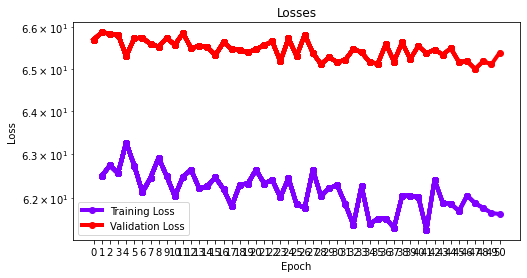

In [482]:
import os
import time


data = './data/data.txt'
prep = data + '.prep'
if not os.path.isfile(prep):
    preprocess(data, prep)


min_count = 10
d_embed = 200
n_aspects = 15
w2v = prep + '.w2v'

abae_path = prep + '.abae.pt'
device = 'cpu'

aspector = aspect_model(prep, w2v, min_count, d_embed, n_aspects, device)
if os.path.isfile(abae_path):
    aspector.load_abae(abae_path)


x = (aspector.w2v.n_vocab, aspector.w2v.d_embed, aspector.w2v.n_aspects)
print('n_vocab: %d | d_embed: %d | n_aspects: %d' % x)


split = {'train': 0.9, 'val': 0.05, 'test': 0.05}
with dataloader(aspector.w2v.w2i, prep, split=split) as dl:

    epochs = 50
    epochsize = 100
    batchsize = 4
    negsize = 20
    initial_lr = 0.0001

    if epochs > 0:
        train(aspector.ab, dl, 
              device=device,
              epochs=epochs, 
              epochsize=epochsize,
              batchsize=batchsize,
              negsize=negsize,
              initial_lr=initial_lr)

        aspector.save_abae(abae_path)